### Tracer content budget within layers of another tracer
Conservation of the mass of tracer with concentration $\phi$, within a volume defined by contours of $\lambda$ is given by  
$$ \partial_t\Phi(\lambda',t) = \mathcal{E}_\phi(\lambda',t) + \sum_n \mathcal{P}^{(n)}_\phi(\lambda',t) \, dV \, $$
where
$$ \Phi(\lambda',t) = \iiint_{\lambda \geq \lambda'} \rho(x,y,z,t)\phi(x,y,z,t) \, dV \, , $$
is the total mass of tracer within the volume,
$$ \mathcal{E}_\phi(\lambda',t) = \frac{\partial}{\partial \lambda}\iiint_{{\lambda}(x,y,z,t)\leq\lambda'} \phi(x,y,z,t) \rho(x,y,z,t) \dot{\lambda}(x,y,z,t) \, dV \, , $$
is the transport of tracer due to dia-boundary masss transport (watermasss transformation), and 
$$\mathcal{P}^{(n)}_\phi(\lambda',t) = \iiint_{\lambda \geq \lambda'} \dot{\phi}^{(n)}(x,y,z,t) \, dV \, .$$
is the volume-integrated tendency of $\phi$ due to process $n$.

In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import budgetcalcs as bc
import calc_wmt as wmt
from dask.diagnostics import ProgressBar
%matplotlib inline

In [2]:
from distributed import Client, LocalCluster, progress
from dask_jobqueue import SLURMCluster

cluster = LocalCluster(
    threads_per_worker=16,
    n_workers=2,
    dashboard_address=8726,
    processes=False)

# cluster = SLURMCluster(
#     queue='analysis',
#     cores=4,
#     project='gdfl_o',
#     memory="24GB",
#     walltime="00:30:00",
#     scheduler_options={"dashboard_address": ":8726"},
# )
# cluster.scale(1)

client = Client(cluster)
client

Client Scheduler: inproc://140.208.147.171/22436/1 Dashboard: http://140.208.147.171:8726/status,Cluster Workers: 2 Cores: 32 Memory: 541.57 GB


***
### Preparation

In [3]:
# rootdir = '/archive/gam/MOM6-examples/ice_ocean_SIS2/Baltic_OM4_025/1yr/'
rootdir = '/archive/gam/ESM4/DECK/ESM4_piControl_D/gfdl.ncrc4-intel16-prod-openmp/7/history/'
averaging = '5daily'
vgrid = 'native'
dtst = '08990101'
ds = {}
files = ['common','heat','salt','thk','o2','no3']
for f in files:
    print('Loading '+f+'.')
    if f=='common':
        filename = dtst+'.ocean_'+averaging+'_'+vgrid+'_'+dtst[0:2]+'*.nc'
    else:
        filename = dtst+'.ocean_'+f+'_'+averaging+'_'+vgrid+'_'+dtst[0:2]+'*.nc'
    ds[f] = xr.open_mfdataset(rootdir+filename, chunks={'time': 1}, combine='by_coords')
    
filename_grid = dtst+'.ocean_static.nc'
delta_t = ds['heat']['average_DT'].astype('timedelta64[s]')
grid = xr.open_dataset(rootdir+filename_grid)
area = grid['areacello']

rho0 = 1035.0
cp = 3992.0

if vgrid == 'z':
    ds = ds.rename({'z_l':'zl'})

filename_snap = dtst+'.ocean_'+averaging+'_'+vgrid+'_snap*.nc'
ds_snap = xr.open_mfdataset(rootdir+filename_snap, chunks={'time': 1}, combine='by_coords')

Loading common.


/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


Loading heat.


/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


Loading salt.


/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


Loading thk.


/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


Loading o2.


/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


Loading no3.


/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


In [4]:
# Budget terms
terms = {}
terms['heat'] = ['opottemptend','T_advection_xy','Th_tendency_vert_remap',
              'boundary_forcing_heat_tendency','internal_heat_heat_tendency',
              'opottempdiff','opottemppmdiff','frazil_heat_tendency']
terms['salt'] = ['osalttend','S_advection_xy','Sh_tendency_vert_remap',
              'boundary_forcing_salt_tendency','osaltdiff','osaltpmdiff']
terms['thkcello'] = ['dhdt','dynamics_h_tendency','vert_remap_h_tendency',
           'boundary_forcing_h_tendency']
terms['o2'] = ['o2h_tendency','o2_advection_xy','o2h_tendency_vert_remap',
            'o2_dfxy_cont_tendency','o2_vdiffuse_impl','jo2']
terms['no3'] = ['no3h_tendency','no3_advection_xy','no3h_tendency_vert_remap',
              'no3_dfxy_cont_tendency','no3_vdiffuse_impl','jno3']

better_names = {}
better_names['thkcello'] = {'thkcello':'volume',
                            'dCdt':'dCdt','E_c':'water mass transformation','residual':'residual',
                            'boundary_forcing_h_tendency':'boundary flux'}
better_names['temp'] = {'temp':'temperature',
                        'total':'total',
                       'boundary_forcing_heat_tendency':'surface forcing',
                       'internal_heat_heat_tendency':'geothermal heating',
                       'opottempdiff':'vertical diffusion',
                       'opottemppmdiff':'isoneutral diffusion',
                       'frazil_heat_tendency':'frazil ice formation'}
better_names['o2'] = {'o2':'oxygen',
                      'dCdt':'dCdt','E_c':'water mass transformation','residual':'residual',
                      'o2_dfxy_cont_tendency':'isoneutral diffusion',
                      'o2_vdiffuse_impl':'vertical diffusion',
                      'jo2':'biogeochemical total',
                      'o2_stf_3d':'surface flux',
                      'o2_btf_3d':'sediment flux',
                      'jo2resp_wc':'water-column respiration'}
better_names['no3'] = {'no3':'nitrate',
                       'dCdt':'dCdt','E_c':'water mass transformation','residual':'residual',
                       'no3_dfxy_cont_tendency':'isoneutral diffusion',
                       'no3_vdiffuse_impl':'vertical diffusion',
                       'jno3':'biogeochemical total',
                       'no3_stf_3d':'surface flux',
                       'no3_btf_3d':'sediment flux',
                       'jno3denit_wc':'water-column denitrification'}

# Bin spacing
dls = {}
dls['temp'] = 0.5
dls['o2'] = 0.5E-6
dls['no3'] = 0.5E-5
# Bins
l_is = {}
l_is['temp'] = np.arange(-4,36.5,dls['temp'])
l_is['o2'] = np.arange(-5E-4,5.5E-4,dls['o2'])
l_is['no3'] = np.arange(-5E-5,3E-4,dls['no3'])

# Additional terms for bgc variables (not explicitly part of the budget)
extra_terms = {}
extra_terms['thkcello'] = []
extra_terms['o2'] = ['o2_stf_3d','o2_btf_3d','jo2resp_wc']
extra_terms['no3'] = ['no3_stf_3d','no3_btf_3d','jno3denit_wc']

In [5]:
# Corrections for o2 budget
# Correct MOM6 tendencies to account for mass in cell
# i.e. convert from [mol kg^-1 m s^-1] to [mol m^-2 s^-1]
for term in terms['o2'][:-1]:
    ds['o2'][term] *= rho0
       
### THIS A HACK WHILE I WORK OUT THE VDIFFUSE_IMPL TERMS ###
# Calculate residual error
# OXYGEN
tendsum,error = bc.calc_budget(ds['o2'],terms['o2'][1:],terms['o2'][0],plot=False)
ds['o2']['o2_vdiffuse_impl']=error

# Corrections for no3 budget
# Correct MOM6 tendencies to account for mass in cell
# i.e. convert from [mol kg^-1 m s^-1] to [mol m^-2 s^-1]
for term in terms['no3'][:-1]:
    ds['no3'][term] *= rho0
    
### THIS A HACK WHILE I WORK OUT THE VDIFFUSE_IMPL TERMS ###
# Calculate residual error
# OXYGEN
tendsum,error = bc.calc_budget(ds['no3'],terms['no3'][1:],terms['no3'][0],plot=False)
ds['no3']['no3_vdiffuse_impl']=error

In [278]:
%%time
ds_l = 'heat'
l_name = 'temp'
ds_c = 'thk'
c_name = 'thkcello'

calc_extra_processes = False
calc_individualterms = True

# Time-mean fields
print('Loading time-mean fields.')
l = ds[ds_l][l_name]
c = ds[ds_c][c_name]

# Snapshots: for evaluating budget tracer content tendency
# NOTE: time-mean i corresponds to the snapshots at i and i-1
# so, for example, diff(snap[1]-snap[0])/dt = mean[1]
print('Loading snapshots.')
l_snap = ds_snap[l_name] # Snapshots of volume-defining tracer
c_snap = ds_snap[c_name] # Snapshots of volume-defining tracer
h_snap = ds_snap['thkcello'] # Snapshots of layer thickness (for tracer content calculation)

# Set conditions for mass transport formulation
if c_name=='thkcello':
    c = xr.ones_like(c)
    c_snap = xr.ones_like(c_snap)

Loading time-mean fields.
Loading snapshots.
CPU times: user 3 ms, sys: 0 ns, total: 3 ms
Wall time: 3.08 ms


***
### Calculations

In [280]:
# Material derivatives
termsLHS = terms[ds_l][:3]
signsLHS = [-1,1,1]
termsRHS = terms[ds_l][3:]
signsRHS = np.ones(len(termsRHS))
dl = {}
for term in termsRHS:
    dl[term] = ds[ds_l][term]
Dl, dl['total'], error = bc.calc_materialderivative(ds[ds_l],termsLHS,signsLHS,termsRHS,signsRHS,plot=False)

# Recast as a tendency in layer integrated temperature
if ds_l == 'heat':
    dl['total'] = dl['total']/cp
    for term in termsRHS:
        dl[term] = dl[term]/cp

In [281]:
# Tricky case: all contours
l_i_vals = l_is[l_name]

In [282]:
# Tracer content tendency
C = wmt.calc_P(rho0*c_snap*h_snap,l_snap,l_i_vals,area) # Binning at snapshots
dCdt = (C.diff('time').assign_coords({'time':ds[ds_l]['time'][1:]}))/delta_t[1:].astype('float')
# WMT
E_c = {}
if calc_individualterms:
    for term in termsRHS:
        E_c[term] = wmt.calc_E(c,l,dl[term],l_i_vals,area)[1:,:]
E_c['total'] = wmt.calc_E(c,l,dl['total'],l_i_vals,area)[1:,:]

In [283]:
# Forcing tendencies
processes = {}
for term in terms[c_name][3:]:
    processes[term] = wmt.calc_P(ds[ds_c][term],l,l_i_vals,area)[1:,:]

In [284]:
%%time
# Extra processes that you wish to display
extra_processes = {}
if calc_extra_processes:
    notloaded = True
    for term in extra_terms[c_name]:
        print('Calculating '+term+'.')
        if (term==c_name+'_stf_3d') or (term==c_name+'_btf_3d'):
            if notloaded:
                print('Loading array for 3d fluxes.')
                loaded = xr.zeros_like(ds[ds_c][c_name]).load()
                notloaded=False
            if term==c_name+'_stf_3d':
                # Create 3D stf array (just stf in the top layer)
                ds[ds_c][term] = loaded.copy()
                ds[ds_c][term].loc[{'zl':ds[ds_c]['zl'].isel(zl=0)}]=ds[ds_c][c_name+'_stf']
            if term==c_name+'_btf_3d':
                # Create 3D btf array (just btf in the bottom layer)
                # Negative because of sign of btf term
                ds[ds_c][term] = loaded.copy()
                ds[ds_c][term].loc[{'zl':ds[ds_c]['zl'].isel(zl=-1)}]=-1*ds[ds_c][c_name+'_btf']
        extra_processes[term] = wmt.calc_P(ds[ds_c][term],l,l_i_vals,area)[1:,:]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.3 µs


In [285]:
%%time
with ProgressBar():
    # Load the bits that are needed
    print('Loading dCdt.')
    dCdt.load()
    
    print('Loading E_c...')
    if calc_individualterms:
        for term in termsRHS:
            print('...contribution from '+term+'.')
            E_c[term].load()
    E_c['total'].load()
        
    for term in terms[c_name][3:]:
        print('Loading '+term+'.')
        processes[term].load()
        
    if calc_extra_processes:
        for term in extra_terms[c_name]:
            print('Loading '+term+'.')
            extra_processes[term].load()

Loading dCdt.
Loading E_c...
...contribution from boundary_forcing_heat_tendency.
...contribution from internal_heat_heat_tendency.
...contribution from opottempdiff.
...contribution from opottemppmdiff.
...contribution from frazil_heat_tendency.
Loading boundary_forcing_h_tendency.
CPU times: user 27min 58s, sys: 35min 22s, total: 1h 3min 20s
Wall time: 18min 40s


In [286]:
residual = dCdt-E_c['total']
for term in terms[c_name][3:]:
    residual -= processes[term]

In [287]:
ds_calcd.close()

In [288]:
dCdt.name = 'dCdt'

E_c['total'].name = 'E_c'
ds_layer = xr.merge([dCdt,E_c['total']])
if calc_individualterms:
    for term in termsRHS:
        E_c[term].name = 'E_c_'+term
        ds_layer = xr.merge([ds_layer,E_c[term]])

for term in terms[c_name][3:]:
    processes[term].name = term
    ds_layer = xr.merge([ds_layer,processes[term]])
    
if calc_extra_processes:
    for term in extra_terms[c_name]:
        extra_processes[term].name = term
        ds_layer = xr.merge([ds_layer,extra_processes[term]])
        
residual.name = 'residual'
ds_layer = xr.merge([ds_layer,residual])

path='data/processed/wmt_'+c_name+'-in-'+l_name+'_dl-'+str(dls[l_name])+'.nc'
ds_layer.to_netcdf(path=path,mode='w')

***
### Plots

In [309]:
l_name = 'temp'
c_name = 'o2'
dl = dls[l_name]
path = 'data/processed/wmt_'+c_name+'-in-'+l_name+'_dl-'+str(dl)+'.nc'
ds_calcd = xr.open_dataset(path)
figpath = 'figures/'+c_name+'-in-'+l_name+'_dl-'+str(dls[l_name])+'/'
calc_individualterms=True

In [316]:
colors={}
colors['no3'] = {'dCdt':'gray','E_c':'lightcoral','F_c':'cornflowerblue','residual':'hotpink',
                 'no3_dfxy_cont_tendency':'khaki',
                 'no3_vdiffuse_impl':'thistle',
                 'jno3':'seagreen',
                 'no3_stf_3d':'cornflowerblue',
                 'no3_btf_3d':'goldenrod',
                 'jno3denit_wc':'aquamarine'}
colors['o2'] = {'dCdt':'gray','E_c':'lightcoral','residual':'hotpink',
                 'o2_dfxy_cont_tendency':'khaki',
                 'o2_vdiffuse_impl':'thistle',
                 'jo2':'seagreen',
                 'o2_stf_3d':'cornflowerblue',
                 'o2_btf_3d':'goldenrod',
                 'jo2resp_wc':'aquamarine'}
colors['temp'] = {'temp':'lightcoral',
                        'total':'lightcoral',
                       'boundary_forcing_heat_tendency':'lightcoral',
                       'internal_heat_heat_tendency':'lightcoral',
                       'opottempdiff':'lightcoral',
                       'opottemppmdiff':'lightcoral',
                       'frazil_heat_tendency':'lightcoral'}
colors['thkcello'] = {'dCdt':'gray','E_c':'lightcoral','residual':'hotpink',
                 'boundary_forcing_h_tendency':'cornflowerblue'}
markers = {}
markers['temp'] = {'dCdt':'',
                 'total':'',
                 'boundary_forcing_heat_tendency':'o',
                 'internal_heat_heat_tendency':'+',
                 'opottempdiff':'s',
                 'opottemppmdiff':'d',
                 'frazil_heat_tendency':'x'}

In [317]:
ylims = {}
ylims['thkcello'] = {'timemean':[-6E10,6E10]}
ylims['no3'] = {'timesum':[-8E7,8E7],'timemean':[-1.1E6,1.1E6],'diffusiveflux':[-4E7,4E7],'timemean_formation':[-1.3E5,1.3E5]}
ylims['o2'] = {'timesum':[-9E8,9E8],'timemean':[-1.5E7,1.5E7],'diffusiveflux':[-8E8,4E8],'timemean_formation':[-1.4E6,1.4E6]}
xlims = {}
xlims['temp'] = [-3,35]
title = better_names[c_name][c_name]
xlabel = better_names[l_name][l_name]

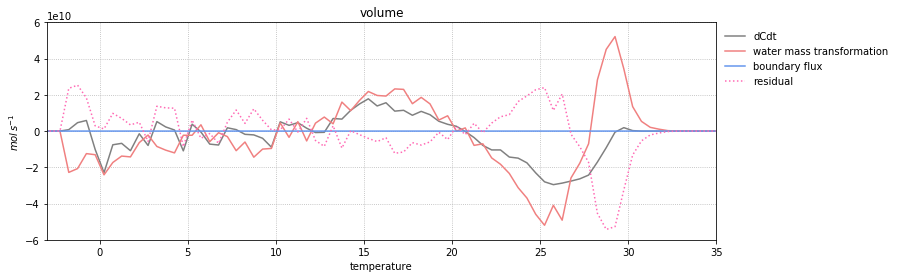

In [306]:
figname = 'annualmean_budget'

ds_now = ds_calcd.copy()
for term in extra_terms[c_name]:
    ds_now = ds_now.drop(term)
if calc_individualterms:
    for term in termsRHS:
        ds_now = ds_now.drop('E_c_'+term)
    
fig,ax = plt.subplots(figsize=(12,4))

for var in ds_now.data_vars:
    if var=='residual':
        linestyle=':'
    else:
        linestyle='-'
    ax.plot(ds_now[var][l_name+'_bin'],ds_now[var].mean('time'),
            label=better_names[c_name][var],
            color=colors[c_name][var],
            linestyle=linestyle)

ax.set_ylim(ylims[c_name]['timemean'])
ax.set_xlim(xlims[l_name])
ax.grid(linestyle=':')
lgd = ax.legend(frameon=False,bbox_to_anchor=(1,1))
ax.set_title(title)
ax.set_xlabel(xlabel)
ax.set_ylabel('$mol\,s^{-1}$')

fig.savefig(figpath+figname,transparent=True,orientation='landscape',dpi=600,bbox_extra_artists=(lgd,), bbox_inches='tight')

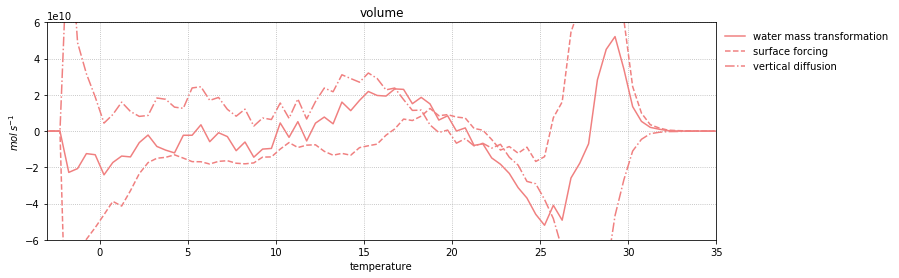

In [308]:
figname = 'annualmean_Eterms'

ds_now = ds_calcd.copy()
for term in extra_terms[c_name]:
    ds_now = ds_now.drop(term)
    
plot_terms = ['dCdt','E_c','E_c_buoyancy_forcing_heat_tendency','opottempdiff','residual']
fig,ax = plt.subplots(figsize=(12,4))

ax.plot(ds_now['E_c'][l_name+'_bin'],ds_now['E_c'].mean('time'),
                label=better_names[c_name]['E_c'],
                color=colors[c_name]['E_c'],
                linestyle='-')
ax.plot(ds_now['E_c_boundary_forcing_heat_tendency'][l_name+'_bin'],ds_now['E_c_boundary_forcing_heat_tendency'].mean('time'),
                label=better_names[l_name]['boundary_forcing_heat_tendency'],
                color=colors[l_name]['boundary_forcing_heat_tendency'],
                linestyle='--')
ax.plot(ds_now['E_c_opottempdiff'][l_name+'_bin'],ds_now['E_c_opottempdiff'].mean('time'),
                label=better_names[l_name]['opottempdiff'],
                color=colors[l_name]['opottempdiff'],
                linestyle='-.')

ax.set_ylim(ylims[c_name]['timemean'])
ax.set_xlim(xlims[l_name])
ax.grid(linestyle=':')
lgd = ax.legend(frameon=False,bbox_to_anchor=(1,1))
ax.set_title(title)
ax.set_xlabel(xlabel)
ax.set_ylabel('$mol\,s^{-1}$')

fig.savefig(figpath+figname,transparent=True,orientation='landscape',dpi=600,bbox_extra_artists=(lgd,), bbox_inches='tight')

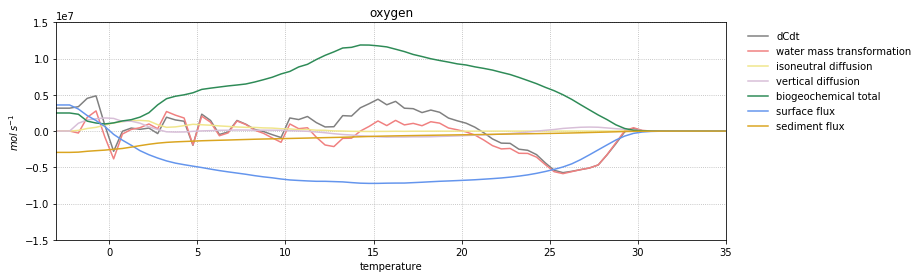

In [329]:
figname = 'annualmean_budget_Ec-corrected'

ds_now = ds_calcd.copy()
ds_now['E_c'] = ds_now['E_c']+ds_now['residual']
ds_now = ds_now.drop('residual')
# Correct vertical diffusion
ds_now[c_name+'_vdiffuse_impl'] = ds_now[c_name+'_vdiffuse_impl']-ds_now[c_name+'_stf_3d']-ds_now[c_name+'_btf_3d']
# Drop resp/denit
ds_now = ds_now.drop(extra_terms[c_name][-1])
    
fig,ax = plt.subplots(figsize=(12,4))
val=np.zeros(len(ds_now['temp_bin']))
for var in ds_now.data_vars:
    if var=='residual':
        linestyle=':'
    else:
        linestyle='-'
    ax.plot(ds_now[var][l_name+'_bin'],ds_now[var].mean('time'),
            label=better_names[c_name][var],
            color=colors[c_name][var],
            linestyle=linestyle)
    
    val += ds_now[var].mean('time').values

ax.set_ylim(ylims[c_name]['timemean'])
ax.set_xlim(xlims[l_name])
ax.grid(linestyle=':')
lgd=ax.legend(frameon=False,bbox_to_anchor = (1.02,1))
ax.set_title(title)
ax.set_xlabel(xlabel)
ax.set_ylabel('$mol\,s^{-1}$')

fig.savefig(figpath+figname,transparent=True,orientation='landscape',dpi=600,bbox_extra_artists=(lgd,), bbox_inches='tight')

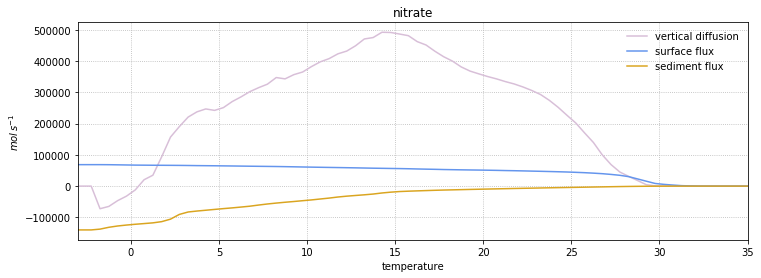

In [105]:
figname = 'annualmean_boundary-fluxes'

ds_now = ds_calcd.copy()
# ds_now[c_name+'_btf_3d'] *= -1
ds_now[c_name+'_vdiffuse_impl'] = ds_now[c_name+'_vdiffuse_impl']-ds_now[c_name+'_stf_3d']-ds_now[c_name+'_btf_3d']
plot_terms = [c_name+'_vdiffuse_impl',c_name+'_stf_3d',c_name+'_btf_3d']
    
fig,ax = plt.subplots(figsize=(12,4))

for var in plot_terms:
    if var=='residual':
        linestyle=':'
    else:
        linestyle='-'
        
    ax.plot(ds_now[var][l_name+'_bin'],ds_now[var].mean('time'),
            label=better_names[c_name][var],
            color=colors[c_name][var],
            linestyle=linestyle)

# ax.set_ylim(ylims[c_name]['timemean'])
ax.set_xlim(xlims[l_name])
ax.grid(linestyle=':')
lgd=ax.legend(frameon=False,bbox_to_anchor = (1,1))
ax.set_title(title)
ax.set_xlabel(xlabel)
ax.set_ylabel('$mol\,s^{-1}$')

fig.savefig(figpath+figname,transparent=True,orientation='landscape',dpi=600,bbox_extra_artists=(lgd,), bbox_inches='tight')

/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


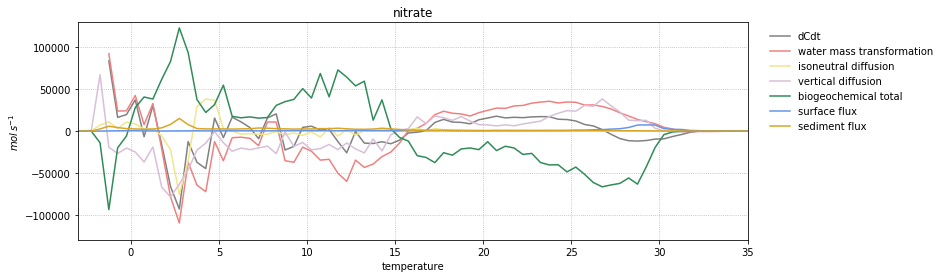

In [268]:
figname = 'annualmean_budget_layers_smoothed'
## FORMATION
# Combin E_c and residual
ds_now = ds_calcd.copy()
ds_now[c_name+'_btf_3d'] *= -1
ds_now['E_c'] = ds_now['E_c']+ds_now['residual']
ds_now = ds_now.drop('residual')
# Correct vertical diffusion
ds_now[c_name+'_vdiffuse_impl'] = ds_now[c_name+'_vdiffuse_impl']-ds_now[c_name+'_stf_3d']-ds_now[c_name+'_btf_3d']
# Drop resp/denit
ds_now = ds_now.drop(extra_terms[c_name][-1])

# Smooth noisy terms
smoothing=8
ds_now['dCdt'] = ds_now['dCdt'].rolling({l_name+'_bin':smoothing},center=True).mean()
ds_now['E_c'] = ds_now['E_c'].rolling({l_name+'_bin':smoothing},center=True).mean()

ds_now = -1*ds_now.diff(l_name+'_bin',n=1)

fig,ax = plt.subplots(figsize=(12,4))

for var in ds_now.data_vars:
    if var=='residual':
        linestyle=':'
    else:
        linestyle='-'
    ax.plot(ds_now[var][l_name+'_bin'],ds_now[var].mean('time'),
            label=better_names[c_name][var],
            color=colors[c_name][var],
            linestyle=linestyle)
    
ax.set_ylim(ylims[c_name]['timemean_formation'])
ax.set_xlim(xlims[l_name])
ax.grid(linestyle=':')
lgd=ax.legend(frameon=False,bbox_to_anchor=(1.02,1))
ax.set_title(title)
ax.set_xlabel(xlabel)
ax.set_ylabel('$mol\,s^{-1}$')
fig.savefig(figpath+figname,transparent=True,orientation='landscape',dpi=600,bbox_extra_artists=(lgd,), bbox_inches='tight')

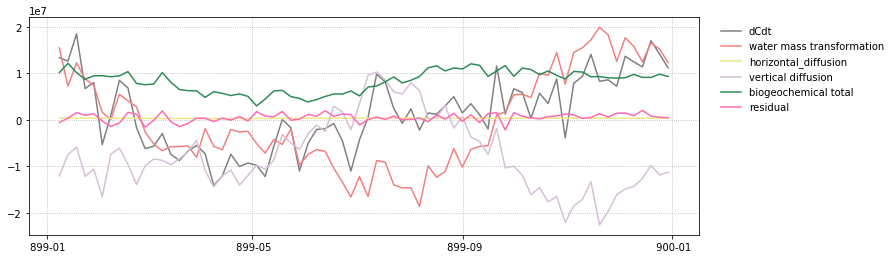

In [266]:
l_c = 10
# Combine E_c and residual
ds_now = ds_calcd.copy()
# ds_now['E_c'] = ds_now['E_c']+ds_now['residual']
# ds_now = ds_now.drop('residual')
for term in extra_terms[c_name]:
    ds_now = ds_now.drop(term)
    
smoothing=30
ds_now = ds_now.rolling({l_name+'_bin':smoothing},center=True).mean()

fig,ax = plt.subplots(figsize=(12,4))

for var in ds_now.data_vars:
    ax.plot(ds_now[var]['time'],ds_now[var].sel({l_name+'_bin':l_c},method='nearest'),label=better_names[c_name][var],color=colors[c_name][var])

# ax.set_ylim(ylims[c_name]['timesum'])
# ax.set_xlim(xlims[l_name])
ax.grid(linestyle=':')
ax.legend(frameon=False,bbox_to_anchor = (1.02,1))